# FPR Analysis

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
import imp
import time

In [258]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

In [259]:
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/x_inactivation_data/'

### Set up the simulations

In [260]:
def get_parameters(observed, p_hat):
    
    mu_hat_closed = np.log(observed.mean()) - np.log(p_hat) - (1/2)*np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1)
    sigma_hat_closed = np.sqrt(np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1))
    
    return mu_hat_closed, sigma_hat_closed

In [261]:
def get_dropout(data, p):
    
    ground_truth_counts = np.round(data).astype(np.int64)
    observed = np.random.binomial(n=ground_truth_counts, p=p)
    
    return observed

In [472]:
def get_clean_count(N, p):
    
    return int(N * p**2/4)

In [493]:
N = 10000
p = 0.2
N_clean = 1000
num_trials = 3000


data_trials = np.zeros(num_trials)
clean_trials = np.zeros(num_trials)
clean_stat_trials = np.zeros(num_trials)
data_stat_trials = np.zeros(num_trials)

mu_hats = np.zeros(num_trials)
sigma_hats = np.zeros(num_trials)

clean_mu_hats = np.zeros(num_trials)
clean_sigma_hats = np.zeros(num_trials)

for trial in range(num_trials):
    
    data1 = np.exp(stats.norm.rvs(loc=0, scale=3, size=N))
    data2 = np.exp(stats.norm.rvs(loc=0, scale=1, size=N))
    
    observed1 = get_dropout(data1, p)
    observed2 = get_dropout(data2, p)
    
    mu_hat1, sigma_hat1 = get_parameters(observed1, p)
    mu_hat2, sigma_hat2 = get_parameters(observed2, p)
        
    stat, pval = stats.ttest_ind_from_stats(
        mu_hat1, sigma_hat1, N_clean,
        mu_hat2, sigma_hat2, N_clean,
        equal_var=False)
    
    
    data_trials[trial] = pval
    data_stat_trials[trial] = stat
    
    mu_hats[trial] = mu_hat1
    sigma_hats[trial] = sigma_hat1
    
    
    clean1 = stats.norm.rvs(loc=1, scale=3, size=N_clean)
    clean2 = stats.norm.rvs(loc=1, scale=1, size=N_clean)
    
    stat_clean, pval_clean = stats.ttest_ind(clean1, clean2, equal_var=False)
    clean_stat_trials[trial] = stat_clean

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


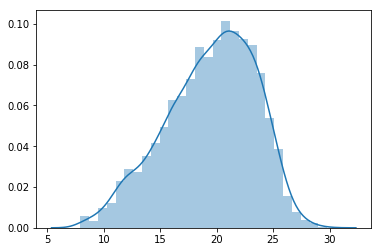

In [495]:
sns.distplot(data_stat_trials);

In [496]:
stat

22.431199512443776

In [473]:
N = 10000
p = 0.2
N_clean = get_clean_count(N, p)
num_trials = 3000


data_trials = np.zeros(num_trials)
clean_trials = np.zeros(num_trials)

mu_hats = np.zeros(num_trials)
sigma_hats = np.zeros(num_trials)

clean_mu_hats = np.zeros(num_trials)
clean_sigma_hats = np.zeros(num_trials)

for trial in range(num_trials):
    
    data1 = np.exp(stats.norm.rvs(loc=1, scale=2, size=N))
    data2 = np.exp(stats.norm.rvs(loc=1, scale=2, size=N))
    
    observed1 = get_dropout(data1, p)
    observed2 = get_dropout(data2, p)
    
    mu_hat1, sigma_hat1 = get_parameters(observed1, p)
    mu_hat2, sigma_hat2 = get_parameters(observed2, p)
    
    clean1 = stats.norm.rvs(loc=1, scale=2, size=N_clean)
    clean2 = stats.norm.rvs(loc=1, scale=2, size=N_clean)
    
    stat, pval = stats.ttest_ind_from_stats(
        mu_hat1, sigma_hat1, N_clean,
        mu_hat2, sigma_hat2, N_clean,
        equal_var=False)
    
    stat_clean, pval_clean = stats.ttest_ind(clean1, clean2, equal_var=False)
    
    data_trials[trial] = pval
    clean_trials[trial] = pval_clean
    
    clean_mu_hats[trial] = clean1.mean()
    clean_sigma_hats[trial] = np.sqrt(clean1.var())
    
    mu_hats[trial] = mu_hat1
    sigma_hats[trial] = sigma_hat1

In [474]:
(clean_trials < 0.05).mean()

0.05

In [475]:
(data_trials < 0.05).mean()

0.07766666666666666

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'mu')

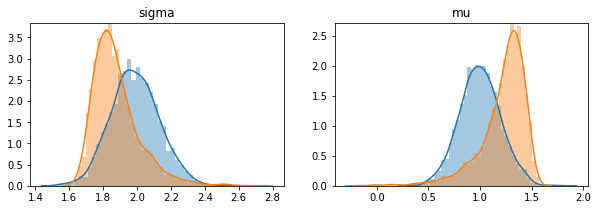

In [476]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1);
sns.distplot(clean_sigma_hats);
sns.distplot(sigma_hats[~np.isnan(sigma_hats)]);
plt.title('sigma')

plt.subplot(1, 2, 2);
sns.distplot(clean_mu_hats);
sns.distplot(mu_hats);
plt.title('mu')


(0, 10)

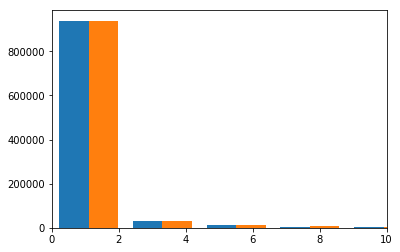

In [253]:
recon = get_dropout(np.exp(stats.norm.rvs(loc=0.0823444581352294, scale=1.9530413250881016, size=N)),
        p=0.1)
plt.hist([observed1, recon], bins=1000);
plt.xlim(0, 10)